In [1]:
## IMPORT LIBRARIES
import os, glob, sys, random, pickle, time, copy

import pandas as pd
import numpy as np
import nibabel as nb
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import nilearn as nil

from nilearn.plotting import plot_glass_brain as glass

from datetime import datetime

from sklearn.model_selection import GroupKFold, ParameterGrid, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, SelectKBest

from scipy.stats import ttest_1samp, t, sem
from scipy.io import loadmat

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
## HERE WE SET A WAITING TIME BEFORE RUNNING THE SCRIPT
## (IN CASE WE ARE WAITING FOR SOME DATA PREPROCESSING PIPELINE)
wait_hours = 0

ctime = time.ctime()
print(f"START: {ctime}\nsleeping for {str(wait_hours)} hours...")
for half in range(int(wait_hours * 2)):
    print(f"\t...{((wait_hours*2)-half)*30} minutes left")
    time.sleep(60 * 30)
print("...done!")

START: Fri Aug 13 17:21:28 2021
sleeping for 0 hours...
...done!


<IPython.core.display.Javascript object>

In [3]:
## DEFINE SOME USEFUL VARIABLES.. 
log = False # if this is True, save all the figures and output a logfile
grid_search = False # if this is True, perform a grid search for the best SVM parameters (gamma, kernel, c)
feature_sel = False # if thi is True, perform feature selection (retain 20 best features)

## ..AND THE CLASSIFICATION FUNCTION THAT WE WILL USE LATER
if grid_search == False:
    def classify(X_r, y_r, runs_idx, roi_name=str):
        kernel = 'linear'
        runs_n = len(np.unique(runs_idx))
        gkf = GroupKFold(n_splits=runs_n)
        performance_step = np.zeros(gkf.n_splits)
        i = 0
        if feature_sel == True:
            X_r = StandardScaler().fit_transform(X_r)
        for train_idx, test_idx in gkf.split(X=X_r, y=y_r, groups=runs_idx):
            print(f'## {sub} ## {roi_name} ## FOLD: {i+1} / {runs_n} ##')
            print("Indices of train-samples: %r" % train_idx.tolist())
            print("Indices of test-samples: %r" % test_idx.tolist())
            print("... which correspond to following runs: %r" %
                  runs_idx[test_idx].tolist())
            # make test train sets
            X_train = X_r[train_idx]
            X_test = X_r[test_idx]
            y_train = y_r[train_idx]
            y_test = y_r[test_idx]

            if feature_sel == True:
                X_scaler = SelectKBest(f_classif, k=20)
                # fit your transformer on the train-set
                X_scaler_fitted = X_scaler.fit(X_train, y_train)
                X_train = X_scaler_fitted.transform(
                    X_train)  # transform your train-set;
                X_test = X_scaler_fitted.transform(
                    X_test)  # transform your test-set;
                idx = X_scaler_fitted.get_support(
                    indices=True)  # get selected features
            # fit
            # (fit your model on the transformed train-set;)
            clf = SVC(kernel=kernel, random_state=42).fit(X_train, y_train)
            # predict (cross-validate to the transformed test-set;)
            y_hat = clf.predict(X_test)
            y_hat_training = clf.predict(X_train)
            performance_step[i] = clf.score(X_test, y_test)
            train_p = clf.score(X_train, y_train)

            # generate reports for each class (confusion matrix and scores in a dict for each class in a run)
            if feature_sel == True:
                print(f'Indices: {idx}')
            print(
                f'TRAINING BATCH: \t{list(y_train)} \nTRAINING PREDICTED: {list(y_hat_training)} \nTARGET: \t\t{list(y_test)} \nPREDICTED: \t{list(y_hat)}')
            print(
                f'TRAINING ACC: {train_p}, TEST ACC: {round(performance_step[i],2)}, STEP: {i+1}\n')
            i += 1
        acc = np.average(performance_step)
        print(f'TOTAL ACCURACY: {acc}\n\n')
        return acc
else:
    def classify(X, y, runs_idx, roi_name=str):
        # Initialise test-train split (leave-one-run-out)
        start = time.time()
        runs_n = len(np.unique(runs_idx))
        roi_acc = []
        roi_clf = []
        if feature_sel == True:
            X = StandardScaler().fit_transform(X)
        for run_id in range(runs_n):
            X_in = X[runs_idx.astype(int) != run_id + 1]
            y_in = y[runs_idx.astype(int) != run_id + 1]
            X_out = X[runs_idx.astype(int) == run_id + 1]
            y_out = y[runs_idx.astype(int) == run_id + 1]

            gkf = GroupKFold(n_splits=runs_n - 1)
            # Create parameters grid (choose best performing parameters)
            c_values = list(np.geomspace(1e10, 1e-10, 21))
            gamma_values = list(np.geomspace(1e4, 1e-4, 9))
            grid_dict = [{'kernel': [['linear']], 'C':[c_values]}, {
                'kernel': [['rbf']], 'C':[c_values], 'gamma':[gamma_values]}]
            grid = ParameterGrid(grid_dict)
            if feature_sel == True:
                # perform feature selection
                X_scaler = SelectKBest(f_classif, k=20)
                X_scaler_fitted = X_scaler.fit(X_in, y_in)
                X_in = X_scaler_fitted.transform(
                    X_in) 
                X_out = X_scaler_fitted.transform(
                    X_out)
                idx = X_scaler_fitted.get_support(
                    indices=True)

            # Initialise and fit classifier
            svc = SVC(max_iter=1e6, random_state=42)
            clf = GridSearchCV(estimator=svc, param_grid=grid, scoring='accuracy', cv=gkf,
                               refit=True, n_jobs=-1, error_score='raise', return_train_score=True)
            clf.fit(X=X_in, y=y_in,
                    groups=runs_idx[runs_idx.astype(int) != run_id + 1])
            # Get and print results for best params set
            params = clf.best_params_
            test_acc = clf.best_score_
            train_acc = clf.cv_results_['mean_train_score'][clf.best_index_]

            outer_clf = clf.best_estimator_.score(X_out, y_out)
            roi_acc.append(outer_clf)
            roi_clf.append(clf.best_estimator_)

        test_acc = np.average(roi_acc)
        end = time.time()
        print(f'ROI: {roi_name}')
        print(f'Best parameters: {params}')
        print(f'Training accuracy: {train_acc}\nTest accuracy: {test_acc}\nTime: {round(end-start, 2)} sec')
        print(f'Test accuracy: {test_acc}\nTime: {round(end-start, 2)} sec')

        return test_acc

## HERE WE DEFINE A SMALL UTILITY FUNCTION TO GET MEAN, CI AND SEM OF A DISTRIBUTION
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sem(a)
    h = se * t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h, se


<IPython.core.display.Javascript object>

In [4]:
## SOME BOOK-KEEPING HERE:

## POINT TO THE RIGHT FOLDERS
out_root = r"E:\2exp_fMRI\Exp\Data\Data\fmri\BIDS\derivatives\MVPA"
out_dir = os.path.join(out_root, "MVPA_blocks_6HMP_norest")
if log == True:
    os.makedirs(out_dir, exist_ok=True)

beta_root = (
    r"E:\2exp_fMRI\Exp\Data\Data\fmri\BIDS\derivatives\SPM\RSA_blocks_1_lev_6HMP"
)
parcel_root = (
    r"E:\2exp_fMRI\Exp\Data\Data\fmri\BIDS\derivatives\parcels\nii\final_parcels"
)
mask_root = r"E:\2exp_fMRI\Exp\Data\Data\fmri\BIDS\derivatives\masks\ok\MNI_realigned_resampled_nii"
fov_mask_root = r"E:\2exp_fMRI\Exp\Data\Data\fmri\BIDS\derivatives\masks\original\original_realignedMNI\fov"

## MAKE ROIs AND COMPARISONS LISTS
comparisons = [
    ("face", "vehicle"),
    ("female", "male"),
    ("bike", "car"),
    ("bike", "car", "female", "male"),
]

rois = ["Foveal", "Peripheral", "Opposite", "FFA", "LOC"]

## INITIALIZE LONG FORMAT DATAFRAME TO STORE ACCURACY VALUES
long_df = pd.DataFrame(None, columns=("sub_id", "comparison", "roi", "acc"))
long_df["sub_id"] = sorted(list(range(2, 26)) * len(comparisons) * len(rois))
long_df["comparison"] = comparisons * len(list(range(2, 26))) * len(rois)
long_df["roi"] = rois * len(comparisons) * len(list(range(2, 26)))
long_df = long_df.sort_values(["sub_id", "roi", "comparison"]).reset_index(drop=True)

## INITIALIZE DATAFRAME TO STORE AND PLOT AGGREGATE RESULTS
graph_df = pd.DataFrame(
    None, columns=("comparison", "roi", "avg", "std", "sem", "cimin", "cimax", "p", "t")
)
graph_df["roi"] = rois * len(comparisons)
graph_df["comparison"] = [
    comparison for comparison in comparisons for i in range(len(rois))
]

print(graph_df)

                   comparison         roi  avg  std  sem cimin cimax    p    t
0             (face, vehicle)      Foveal  NaN  NaN  NaN   NaN   NaN  NaN  NaN
1             (face, vehicle)  Peripheral  NaN  NaN  NaN   NaN   NaN  NaN  NaN
2             (face, vehicle)    Opposite  NaN  NaN  NaN   NaN   NaN  NaN  NaN
3             (face, vehicle)         FFA  NaN  NaN  NaN   NaN   NaN  NaN  NaN
4             (face, vehicle)         LOC  NaN  NaN  NaN   NaN   NaN  NaN  NaN
5              (female, male)      Foveal  NaN  NaN  NaN   NaN   NaN  NaN  NaN
6              (female, male)  Peripheral  NaN  NaN  NaN   NaN   NaN  NaN  NaN
7              (female, male)    Opposite  NaN  NaN  NaN   NaN   NaN  NaN  NaN
8              (female, male)         FFA  NaN  NaN  NaN   NaN   NaN  NaN  NaN
9              (female, male)         LOC  NaN  NaN  NaN   NaN   NaN  NaN  NaN
10                (bike, car)      Foveal  NaN  NaN  NaN   NaN   NaN  NaN  NaN
11                (bike, car)  Peripheral  NaN  NaN 

<IPython.core.display.Javascript object>

BLUE: foveal (2.5 deg size, 0 deg eccentricity)
RED: peripheral normal (2 deg size, 7 deg eccentricity)
ORANGE: peripheral inverted (2 deg size, 7 deg eccentricity)
PINK: LOC
BROWN: FFA


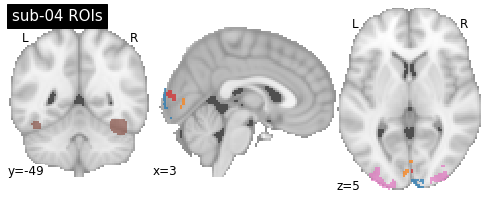

<IPython.core.display.Javascript object>

In [5]:
## SET (PRECOMPUTED) RETINOTOPIC ROIs SIZES 
per_radius = 1.0
fov_radius = 2.0

## LOAD ROIs MASKS
mask_files = { 'sub-' + str(sub_id).zfill(2): {roi: '' for roi in rois} for sub_id in range(2, 26)}
for sub_id in range(2, 26):
    sub = 'sub-' + str(sub_id).zfill(2)
 
    # define ROIs masks locations and import data
    mask_files[sub]['Foveal'] = nb.load(glob.glob(os.path.join(
            fov_mask_root, str(fov_radius), 'Linear', 'resampled_nearest', sub + '*FOV*'))[0]).get_fdata() > 0
    
    # presentation order for pairs of peripheral stimuli (normal: up-right, down-left; inverted: down-right, up-left) 
    # was balanced across subjects, so we need to assign ROIs accordingly 
    if sub_id % 2 == 0:
        mask_files[sub]['Peripheral'] = nb.load(glob.glob(
            os.path.join(mask_root, sub + '*inverted*'))[0]).get_fdata() > 0
        mask_files[sub]['Opposite'] = nb.load(glob.glob(
            os.path.join(mask_root, sub + '*normal*'))[0]).get_fdata() > 0
    else:
        mask_files[sub]['Peripheral'] = nb.load(glob.glob(
            os.path.join(mask_root, sub + '*normal*'))[0]).get_fdata() > 0
        mask_files[sub]['Opposite'] = nb.load(glob.glob(
            os.path.join(mask_root, sub + '*inverted*'))[0]).get_fdata() > 0

    mask_files[sub]['FFA'] = nb.load(glob.glob(
        os.path.join(parcel_root, sub, 'FFA.nii'))[0]).get_fdata() > 0

    mask_files[sub]['LOC'] = nb.load(glob.glob(
        os.path.join(parcel_root, sub, 'LOC.nii'))[0]).get_fdata() > 0

## PLOT ROIs AS AN EXAMPLE
sub = 'sub-04'
rois_img = mask_files[sub]['Foveal'] * 1 + mask_files[sub]['Peripheral'] * 2 + mask_files[sub]['Opposite'] * 3 + mask_files[sub]['FFA'] * 4 + mask_files[sub]['LOC'] * 5 
affine = nb.load(glob.glob(
        os.path.join(parcel_root, sub, 'LOC.nii'))[0]).affine
ni_img = nb.Nifti1Image(rois_img, affine)
cmap = matplotlib.cm.get_cmap('tab10', 7)
nil.plotting.plot_roi(ni_img, colorbar=False, title=f'{sub} ROIs',
                      draw_cross=False, vmin = 1, vmax = 7, cut_coords=(3, -49, 5), cmap = cmap)
print('BLUE: foveal (2.5 deg size, 0 deg eccentricity)\nRED: peripheral normal (2 deg size, 7 deg eccentricity)\nORANGE: peripheral inverted (2 deg size, 7 deg eccentricity)\nPINK: LOC\nBROWN: FFA')


In [6]:
for sub_id in range(2, 26):
    sub = 'sub-' + str(sub_id).zfill(2)
    print(f'#### {sub} ####')
    
    beta_paths = []
    beta_names = []
    beta_classes = []
    beta_runs = []
    beta_bins = []
    
    ## MAKE BETAS MAPPING DATAFRAME
    print('\r', f'STEP: mapping and loading beta images for {sub}...')
    beta_subdirs = ['_fv', '_all']
    for beta_subdir in beta_subdirs:
        beta_loc = os.path.join(beta_root + beta_subdir, sub)
        
        mat = loadmat(os.path.join(beta_loc, 'SPM.mat'))

        beta_path = sorted(
            glob.glob(os.path.join(beta_loc, 'beta*.?ii')))
        
        beta_paths += beta_path
        beta_names += [str(mat['SPM']['Vbeta'][0][0][0][beta_id][0][0]) for beta_id in range(len(beta_path)) if str(
            mat['SPM']['Vbeta'][0][0][0][beta_id][0][0]) == os.path.basename(beta_path[beta_id])]
        beta_classes += [str(mat['SPM']['Vbeta'][0][0][0][beta_id][5][0]).split(' ')[-1].split('*')[0] for beta_id in range(len(
            beta_path)) if str(mat['SPM']['Vbeta'][0][0][0][beta_id][0][0]) == os.path.basename(beta_path[beta_id])]
        beta_runs += [str(mat['SPM']['Vbeta'][0][0][0][beta_id][5][0]).split(' ')[-2].split('(')[-1][0] for beta_id in range(len(
            beta_path)) if str(mat['SPM']['Vbeta'][0][0][0][beta_id][0][0]) == os.path.basename(beta_path[beta_id])]
        beta_bins += [str(mat['SPM']['Vbeta'][0][0][0][beta_id][5][0]).split(' ')[-1].split('(')[-1][0] for beta_id in range(len(beta_path))
                     if str(mat['SPM']['Vbeta'][0][0][0][beta_id][0][0]) == os.path.basename(beta_path[beta_id])]
        
    betas_df = pd.DataFrame(None, columns=(
        'beta_path', 'spm_filename', 'condition', 'run', 'bin', 'array'))

    betas_df['beta_path'] = beta_paths
    betas_df['spm_filename'] = beta_names
    betas_df['condition'] = beta_classes
    betas_df['run'] = beta_runs
    betas_df['bin'] = beta_bins
    betas_df['array'] = [np.array(nb.load(beta).get_fdata())
                         for beta in beta_paths]
    print('done!')
    
    ## DEFINE DATASET FOR CLASSIFICATION
    for comparison in comparisons:
        print(f'### COMPARISON: {comparison}, {sub} ###')
        
        # select only the conditions that we need
        print('\r', f'STEP: defining dataset...')
        dataset_df = betas_df[betas_df.condition.str.match(
            "|".join(list(comparison)))]
        dataset_df = dataset_df.sort_values(
            ['condition', 'run'], axis=0).reset_index(drop=True)
        print('done!')
        
        # remove the mean pattern in each run (cocktail-blank removal)
        print(
            '\r', 'STEP: removing average pattern of all the conditions to classify...')
        dataset_arr = np.array([array for array in dataset_df['array']])
        runs = np.unique(dataset_df['run'].values)
        for run in runs:
            betas_idx = dataset_df['run'] == run
            dataset_arr_run = dataset_arr[betas_idx.values]
            dataset_arr_run_avg = np.array([np.mean(dataset_arr_run, 0)
                                      for rows in range(dataset_arr_run.shape[0])])
            dataset_arr_run_demeaned = dataset_arr_run - dataset_arr_run_avg

            list_id = 0
            for index, beta_idx in enumerate(betas_idx):
                if beta_idx:
                    dataset_df.iloc[index]['array'] = dataset_arr_run_demeaned[list_id]
                    list_id += 1
        print('done!')
        
        print(
            '\r', 'STEP: preparing dataset for classification (zeroing NaNs, shuffling)...')
        for roi_key in mask_files[sub].keys():
            
            # import mask and mask data (zero filled)
            # NOTE: here nans are zeroed, but they can be masked
            # this does not make any difference for classification puproses
            mask = mask_files[sub][roi_key]
            dataset_masked = [np.nan_to_num(df_array[mask], False, 0.0)
                            for df_array in dataset_df['array']]

            # generate dataset
            X = dataset_masked
            y = list(dataset_df['condition'])
            runs_idx = list(dataset_df['run'])

            # shuffle dataset
            comp = list(zip(X, y, runs_idx))
            random.seed(42)
            random.shuffle(comp)
            X, y, runs_idx = zip(*comp)

            # transform back into array
            X = np.array(X)
            y = np.array(y)
            runs_idx = np.array(runs_idx)
            print('done!')
            
            # RUN THE CLASSIFIER (LEAVE-ONE-RUN-OUT)
            # accuracy is averaged over 5 runs (cross-validated)
            print(f'## CLASSIFICATION - {sub} {comparison} ##')
            long_df.loc[((long_df['sub_id'] == sub_id) & (long_df['comparison'] == comparison) & (long_df['roi'] == roi_key)), 'acc'] = classify(
                X, y, runs_idx, roi_name=roi_key)
            


#### sub-02 ####
 STEP: mapping and loading beta images for sub-02...
done!
### COMPARISON: ('face', 'vehicle'), sub-02 ###
 STEP: defining dataset...
done!
 STEP: removing average pattern of all the conditions to classify...
done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-02 ('face', 'vehicle') ##
## sub-02 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['vehicle', 'face', 'face', 'vehicle', 'vehicle', 'vehicle', 'face', 'face'] 
TRAINING PREDICTED: ['vehicle', 'face', 'face', 'vehicle', 'vehicle', 'vehicle', 'face', 'face'] 
TARGET: 		['vehicle', 'face'] 
PREDICTED: 	['face', 'vehicle']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-02 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-02 ('female', 'male') ##
## sub-02 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['female', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-02 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['male

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-02 ('bike', 'car') ##
## sub-02 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-02 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-02 ('bike', 'car', 'female', 'male') ##
## sub-02 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['female', 'car', 'female', 'female']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-02 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to f

TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'car', 'female', 'bike', 'female', 'male', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'car', 'female', 'bike', 'female', 'male', 'car', 'bike', 'bike'] 
TARGET: 		['female', 'male', 'bike', 'car'] 
PREDICTED: 	['bike', 'male', 'car', 'female']
TRAINING ACC: 1.0, TEST ACC: 0.25, STEP: 3

## sub-02 ## LOC ## FOLD: 4 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 14, 16, 17, 18, 19]
Indices of test-samples: [8, 12, 13, 15]
... which correspond to following runs: ['2', '2', '2', '2']
TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike', 'female', 

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-03 ('female', 'male') ##
## sub-03 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['male', 'female']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-03 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['fema

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-03 ('bike', 'car') ##
## sub-03 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-03 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-03 ('bike', 'car', 'female', 'male') ##
## sub-03 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['car', 'car', 'female', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.25, STEP: 1

## sub-03 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to follow

... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['car', 'bike', 'female', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-03 ## LOC ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to following runs: ['4', '4', '4', '4']
TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-04 ('female', 'male') ##
## sub-04 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['male', 'female']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-04 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['fema

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-04 ('bike', 'car') ##
## sub-04 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-04 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-04 ('bike', 'car', 'female', 'male') ##
## sub-04 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['male', 'car', 'bike', 'female']
TRAINING ACC: 1.0, TEST ACC: 0.5, STEP: 1

## sub-04 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to follo

TRAINING BATCH: 	['male', 'female', 'bike', 'car', 'female', 'male', 'car', 'female', 'male', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike'] 
TRAINING PREDICTED: ['male', 'female', 'bike', 'car', 'female', 'male', 'car', 'female', 'male', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike'] 
TARGET: 		['car', 'male', 'female', 'bike'] 
PREDICTED: 	['female', 'bike', 'car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.25, STEP: 5

TOTAL ACCURACY: 0.35


#### sub-05 ####
 STEP: mapping and loading beta images for sub-05...
done!
### COMPARISON: ('face', 'vehicle'), sub-05 ###
 STEP: defining dataset...
done!
 STEP: removing average pattern of all the conditions to classify...
done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-05 ('face', 'vehicle') ##
## sub-05 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAI

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-05 ('female', 'male') ##
## sub-05 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['male', 'female']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-05 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['fema

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-05 ('bike', 'car') ##
## sub-05 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-05 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-05 ('bike', 'car', 'female', 'male') ##
## sub-05 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['male', 'female', 'bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-05 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to follo

TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['male', 'female', 'bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-05 ## LOC ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to following runs: ['4', '4', '4', '4']
TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'bike'] 
TARGET: 		['female', 'male', 'car', '

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-06 ('female', 'male') ##
## sub-06 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['female', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-06 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['male

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-06 ('bike', 'car') ##
## sub-06 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-06 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-06 ('bike', 'car', 'female', 'male') ##
## sub-06 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['car', 'car', 'female', 'female']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-06 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to foll

TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'bike'] 
TARGET: 		['female', 'male', 'car', 'bike'] 
PREDICTED: 	['male', 'male', 'car', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.5, STEP: 2

## sub-06 ## LOC ## FOLD: 3 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 17, 18, 19]
Indices of test-samples: [9, 10, 14, 16]
... which correspond to following runs: ['3', '3', '3', '3']
TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'car', 'female', 'bike', 'female', 'male', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'car', 'female', 'bike', 'female', 'male', 'car', 'bike', 'bike'] 
TARGET: 		['female', 'male', 'bike', 'ca

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-07 ('female', 'male') ##
## sub-07 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['female', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-07 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['male

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-07 ('bike', 'car') ##
## sub-07 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-07 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-07 ('bike', 'car', 'female', 'male') ##
## sub-07 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['female', 'car', 'bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.5, STEP: 1

## sub-07 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to follow

TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike', 'female', 'male'] 
PREDICTED: 	['female', 'car', 'male', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 4

## sub-07 ## LOC ## FOLD: 5 / 5 ##
Indices of train-samples: [0, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19]
Indices of test-samples: [1, 6, 11, 18]
... which correspond to following runs: ['1', '1', '1', '1']
TRAINING BATCH: 	['male', 'female', 'bike', 'car', 'female', 'male', 'car', 'female', 'male', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike'] 
TRAINING PREDICTED: ['male', 'female', 'bike', 'car', 'female', 'male', 'car', 'female', 'male', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike'] 
TARGET: 		['car', 'male', 'female', 'b

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-08 ('female', 'male') ##
## sub-08 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['female', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-08 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['male

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-08 ('bike', 'car') ##
## sub-08 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-08 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-08 ('bike', 'car', 'female', 'male') ##
## sub-08 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['female', 'male', 'male', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-08 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to foll

TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'car', 'female', 'bike', 'female', 'male', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'car', 'female', 'bike', 'female', 'male', 'car', 'bike', 'bike'] 
TARGET: 		['female', 'male', 'bike', 'car'] 
PREDICTED: 	['male', 'car', 'male', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 3

## sub-08 ## LOC ## FOLD: 4 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 14, 16, 17, 18, 19]
Indices of test-samples: [8, 12, 13, 15]
... which correspond to following runs: ['2', '2', '2', '2']
TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike', 'female', 'ma

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-09 ('female', 'male') ##
## sub-09 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['female', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-09 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['male

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-09 ('bike', 'car') ##
## sub-09 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-09 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-09 ('bike', 'car', 'female', 'male') ##
## sub-09 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['car', 'male', 'male', 'female']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-09 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to follo

TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike', 'female', 'male'] 
PREDICTED: 	['female', 'bike', 'bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.25, STEP: 4

## sub-09 ## LOC ## FOLD: 5 / 5 ##
Indices of train-samples: [0, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19]
Indices of test-samples: [1, 6, 11, 18]
... which correspond to following runs: ['1', '1', '1', '1']
TRAINING BATCH: 	['male', 'female', 'bike', 'car', 'female', 'male', 'car', 'female', 'male', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike'] 
TRAINING PREDICTED: ['male', 'female', 'bike', 'car', 'female', 'male', 'car', 'female', 'male', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike'] 
TARGET: 		['car', 'male', 'female', 

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-10 ('female', 'male') ##
## sub-10 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['female', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-10 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['fema

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-10 ('bike', 'car') ##
## sub-10 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-10 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-10 ('bike', 'car', 'female', 'male') ##
## sub-10 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['female', 'male', 'female', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-10 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to fo

TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'car', 'female', 'bike', 'female', 'male', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'car', 'female', 'bike', 'female', 'male', 'car', 'bike', 'bike'] 
TARGET: 		['female', 'male', 'bike', 'car'] 
PREDICTED: 	['car', 'bike', 'male', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 3

## sub-10 ## LOC ## FOLD: 4 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 14, 16, 17, 18, 19]
Indices of test-samples: [8, 12, 13, 15]
... which correspond to following runs: ['2', '2', '2', '2']
TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike', 'female', 'ma

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-11 ('female', 'male') ##
## sub-11 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['male', 'female']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-11 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['male

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-11 ('bike', 'car') ##
## sub-11 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-11 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-11 ('bike', 'car', 'female', 'male') ##
## sub-11 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['car', 'car', 'bike', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.25, STEP: 1

## sub-11 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to followi

... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['car', 'car', 'female', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.25, STEP: 1

## sub-11 ## LOC ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to following runs: ['4', '4', '4', '4']
TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', '

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-12 ('female', 'male') ##
## sub-12 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['female', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-12 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['male

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-12 ('bike', 'car') ##
## sub-12 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-12 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-12 ('bike', 'car', 'female', 'male') ##
## sub-12 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['car', 'car', 'bike', 'female']
TRAINING ACC: 1.0, TEST ACC: 0.25, STEP: 1

## sub-12 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to follo

## sub-12 ## LOC ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['car', 'car', 'male', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-12 ## LOC ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to following runs: ['4', '4', '4', '4']
TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike',

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-13 ('female', 'male') ##
## sub-13 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['male', 'female']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-13 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['male

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-13 ('bike', 'car') ##
## sub-13 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-13 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-13 ('bike', 'car', 'female', 'male') ##
## sub-13 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['bike', 'female', 'male', 'female']
TRAINING ACC: 1.0, TEST ACC: 0.25, STEP: 1

## sub-13 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to f

TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'bike'] 
TARGET: 		['female', 'male', 'car', 'bike'] 
PREDICTED: 	['car', 'bike', 'female', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.25, STEP: 2

## sub-13 ## LOC ## FOLD: 3 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 17, 18, 19]
Indices of test-samples: [9, 10, 14, 16]
... which correspond to following runs: ['3', '3', '3', '3']
TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'car', 'female', 'bike', 'female', 'male', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'car', 'female', 'bike', 'female', 'male', 'car', 'bike', 'bike'] 
TARGET: 		['female', 'male', 'bike',

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-14 ('female', 'male') ##
## sub-14 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['female', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-14 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['fema

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-14 ('bike', 'car') ##
## sub-14 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-14 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-14 ('bike', 'car', 'female', 'male') ##
## sub-14 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['car', 'bike', 'female', 'female']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-14 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to fol

... which correspond to following runs: ['2', '2', '2', '2']
TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike', 'female', 'male'] 
PREDICTED: 	['male', 'bike', 'car', 'female']
TRAINING ACC: 1.0, TEST ACC: 0.25, STEP: 4

## sub-14 ## LOC ## FOLD: 5 / 5 ##
Indices of train-samples: [0, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19]
Indices of test-samples: [1, 6, 11, 18]
... which correspond to following runs: ['1', '1', '1', '1']
TRAINING BATCH: 	['male', 'female', 'bike', 'car', 'female', 'male', 'car', 'female', 'male', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike'] 
TRAINING PREDICTED: ['male', 'female', 'bike', 'car', 'female', 'male', 'car', 'female', 'male', 'bike', 'female', 'bike', 'male'

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-15 ('female', 'male') ##
## sub-15 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['male', 'female']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-15 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['male

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-15 ('bike', 'car') ##
## sub-15 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-15 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-15 ('bike', 'car', 'female', 'male') ##
## sub-15 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['male', 'bike', 'female', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.25, STEP: 1

## sub-15 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to fol

TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['male', 'bike', 'car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.25, STEP: 1

## sub-15 ## LOC ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to following runs: ['4', '4', '4', '4']
TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'bike'] 
TARGET: 		['female', 'male', 'car', 'b

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-16 ('female', 'male') ##
## sub-16 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['male', 'female']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-16 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['male

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-16 ('bike', 'car') ##
## sub-16 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-16 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-16 ('bike', 'car', 'female', 'male') ##
## sub-16 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['bike', 'bike', 'car', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-16 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to followi

TRAINING BATCH: 	['male', 'female', 'bike', 'car', 'female', 'male', 'car', 'female', 'male', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike'] 
TRAINING PREDICTED: ['male', 'female', 'bike', 'car', 'female', 'male', 'car', 'female', 'male', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike'] 
TARGET: 		['car', 'male', 'female', 'bike'] 
PREDICTED: 	['male', 'male', 'female', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.5, STEP: 5

TOTAL ACCURACY: 0.6


#### sub-17 ####
 STEP: mapping and loading beta images for sub-17...
done!
### COMPARISON: ('face', 'vehicle'), sub-17 ###
 STEP: defining dataset...
done!
 STEP: removing average pattern of all the conditions to classify...
done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-17 ('face', 'vehicle') ##
## sub-17 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINI

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-17 ('female', 'male') ##
## sub-17 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['male', 'female']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-17 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['fema

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-17 ('bike', 'car') ##
## sub-17 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-17 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-17 ('bike', 'car', 'female', 'male') ##
## sub-17 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['male', 'female', 'female', 'female']
TRAINING ACC: 1.0, TEST ACC: 0.5, STEP: 1

## sub-17 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to 

TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike', 'female', 'male'] 
PREDICTED: 	['car', 'male', 'female', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.75, STEP: 4

## sub-17 ## LOC ## FOLD: 5 / 5 ##
Indices of train-samples: [0, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19]
Indices of test-samples: [1, 6, 11, 18]
... which correspond to following runs: ['1', '1', '1', '1']
TRAINING BATCH: 	['male', 'female', 'bike', 'car', 'female', 'male', 'car', 'female', 'male', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike'] 
TRAINING PREDICTED: ['male', 'female', 'bike', 'car', 'female', 'male', 'car', 'female', 'male', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike'] 
TARGET: 		['car', 'male', 'female', 

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-18 ('female', 'male') ##
## sub-18 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['male', 'female']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-18 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['fema

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-18 ('bike', 'car') ##
## sub-18 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-18 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-18 ('bike', 'car', 'female', 'male') ##
## sub-18 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['male', 'female', 'female', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.75, STEP: 1

## sub-18 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to fo

... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['male', 'female', 'bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-18 ## LOC ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to following runs: ['4', '4', '4', '4']
TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-19 ('female', 'male') ##
## sub-19 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['female', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-19 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['fema

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-19 ('bike', 'car') ##
## sub-19 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-19 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-19 ('bike', 'car', 'female', 'male') ##
## sub-19 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['bike', 'bike', 'male', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.25, STEP: 1

## sub-19 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to follow

TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'car', 'female', 'bike', 'female', 'male', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'car', 'female', 'bike', 'female', 'male', 'car', 'bike', 'bike'] 
TARGET: 		['female', 'male', 'bike', 'car'] 
PREDICTED: 	['male', 'female', 'bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.5, STEP: 3

## sub-19 ## LOC ## FOLD: 4 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 14, 16, 17, 18, 19]
Indices of test-samples: [8, 12, 13, 15]
... which correspond to following runs: ['2', '2', '2', '2']
TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike', 'female', '

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-20 ('female', 'male') ##
## sub-20 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['male', 'female']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-20 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['male

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-20 ('bike', 'car') ##
## sub-20 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-20 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-20 ('bike', 'car', 'female', 'male') ##
## sub-20 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['bike', 'bike', 'male', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-20 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to follow

TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['bike', 'male', 'male', 'female']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-20 ## LOC ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to following runs: ['4', '4', '4', '4']
TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'bike'] 
TARGET: 		['female', 'male', 'car', 

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-21 ('female', 'male') ##
## sub-21 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['male', 'female']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-21 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['male

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-21 ('bike', 'car') ##
## sub-21 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-21 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-21 ('bike', 'car', 'female', 'male') ##
## sub-21 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['car', 'female', 'bike', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.5, STEP: 1

## sub-21 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to follo

TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike', 'female', 'male'] 
PREDICTED: 	['bike', 'bike', 'female', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.75, STEP: 4

## sub-21 ## LOC ## FOLD: 5 / 5 ##
Indices of train-samples: [0, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19]
Indices of test-samples: [1, 6, 11, 18]
... which correspond to following runs: ['1', '1', '1', '1']
TRAINING BATCH: 	['male', 'female', 'bike', 'car', 'female', 'male', 'car', 'female', 'male', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike'] 
TRAINING PREDICTED: ['male', 'female', 'bike', 'car', 'female', 'male', 'car', 'female', 'male', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike'] 
TARGET: 		['car', 'male', 'female',

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-22 ('female', 'male') ##
## sub-22 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['female', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-22 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['fema

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-22 ('bike', 'car') ##
## sub-22 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-22 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-22 ('bike', 'car', 'female', 'male') ##
## sub-22 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['bike', 'male', 'bike', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.25, STEP: 1

## sub-22 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to follo

TRAINING BATCH: 	['male', 'female', 'bike', 'car', 'female', 'male', 'car', 'female', 'male', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike'] 
TRAINING PREDICTED: ['male', 'female', 'bike', 'car', 'female', 'male', 'car', 'female', 'male', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike'] 
TARGET: 		['car', 'male', 'female', 'bike'] 
PREDICTED: 	['bike', 'bike', 'male', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 5

TOTAL ACCURACY: 0.4


#### sub-23 ####
 STEP: mapping and loading beta images for sub-23...
done!
### COMPARISON: ('face', 'vehicle'), sub-23 ###
 STEP: defining dataset...
done!
 STEP: removing average pattern of all the conditions to classify...
done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-23 ('face', 'vehicle') ##
## sub-23 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAININ

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-23 ('female', 'male') ##
## sub-23 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['female', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-23 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['male

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-23 ('bike', 'car') ##
## sub-23 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 1

## sub-23 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-23 ('bike', 'car', 'female', 'male') ##
## sub-23 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['car', 'male', 'bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.5, STEP: 1

## sub-23 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to followin

TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['female', 'male', 'bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.5, STEP: 1

## sub-23 ## LOC ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to following runs: ['4', '4', '4', '4']
TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'bike'] 
TARGET: 		['female', 'male', 'car', '

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-24 ('female', 'male') ##
## sub-24 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['female', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-24 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['male

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-24 ('bike', 'car') ##
## sub-24 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-24 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-24 ('bike', 'car', 'female', 'male') ##
## sub-24 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['female', 'bike', 'bike', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.25, STEP: 1

## sub-24 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to fol

... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['male', 'bike', 'female', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.25, STEP: 1

## sub-24 ## LOC ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to following runs: ['4', '4', '4', '4']
TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike'

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-25 ('female', 'male') ##
## sub-25 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'female', 'male', 'male', 'male', 'female', 'female'] 
TARGET: 		['male', 'female'] 
PREDICTED: 	['female', 'male']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-25 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TRAINING PREDICTED: ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female'] 
TARGET: 		['female', 'male'] 
PREDICTED: 	['male

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-25 ('bike', 'car') ##
## sub-25 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 5, 8, 9]
Indices of test-samples: [6, 7]
... which correspond to following runs: ['5', '5']
TRAINING BATCH: 	['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'bike', 'car', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 1

## sub-25 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 2, 4, 5, 6, 7, 8, 9]
Indices of test-samples: [1, 3]
... which correspond to following runs: ['4', '4']
TRAINING BATCH: 	['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'bike', 'car', 'car', 'car', 'bike', 'bike', 'bike'] 
TARGET: 		['bike', 'car'] 
PREDICTED: 	['bike', 'car']
TRAINING ACC: 1.0, TEST ACC: 1.0, STEP: 2

## sub-

done!
 STEP: preparing dataset for classification (zeroing NaNs, shuffling)...
done!
## CLASSIFICATION - sub-25 ('bike', 'car', 'female', 'male') ##
## sub-25 ## Foveal ## FOLD: 1 / 5 ##
Indices of train-samples: [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Indices of test-samples: [0, 2, 3, 4]
... which correspond to following runs: ['5', '5', '5', '5']
TRAINING BATCH: 	['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['car', 'female', 'male', 'male', 'car', 'female', 'male', 'female', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['male', 'female', 'bike', 'car'] 
PREDICTED: 	['car', 'female', 'car', 'bike']
TRAINING ACC: 1.0, TEST ACC: 0.25, STEP: 1

## sub-25 ## Foveal ## FOLD: 2 / 5 ##
Indices of train-samples: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18]
Indices of test-samples: [5, 7, 17, 19]
... which correspond to follo

TRAINING BATCH: 	['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TRAINING PREDICTED: ['male', 'car', 'female', 'bike', 'car', 'female', 'male', 'male', 'female', 'male', 'female', 'bike', 'car', 'car', 'bike', 'bike'] 
TARGET: 		['car', 'bike', 'female', 'male'] 
PREDICTED: 	['bike', 'car', 'bike', 'female']
TRAINING ACC: 1.0, TEST ACC: 0.0, STEP: 4

## sub-25 ## LOC ## FOLD: 5 / 5 ##
Indices of train-samples: [0, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19]
Indices of test-samples: [1, 6, 11, 18]
... which correspond to following runs: ['1', '1', '1', '1']
TRAINING BATCH: 	['male', 'female', 'bike', 'car', 'female', 'male', 'car', 'female', 'male', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike'] 
TRAINING PREDICTED: ['male', 'female', 'bike', 'car', 'female', 'male', 'car', 'female', 'male', 'bike', 'female', 'bike', 'male', 'car', 'car', 'bike'] 
TARGET: 		['car', 'male', 'female', '

<IPython.core.display.Javascript object>

In [11]:
## COMPUTE AND PASS RESULTS TO DATAFRAME FOR PLOTTING
print('### T-TEST AND SUMMARY:')
for comparison in comparisons:
    labels_n = len(comparison)
    print(f'## COMPARISON: {comparison}')
    for roi in rois:
        data = long_df.loc[((long_df['comparison'] == comparison) & (long_df['roi'] == roi)), 'acc']
                
        graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['roi'] == roi)), 't'], graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['roi'] == roi)), 'p'] = ttest_1samp(
            data, popmean=1/labels_n, alternative='greater')
        
        graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['roi'] == roi)), 'std'] = np.std(data)

        
        graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['roi'] == roi)), 'avg'], graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['roi'] == roi)), 'cimin'], graph_df.loc[(
        (graph_df['comparison'] == comparison) & (graph_df['roi'] == roi)), 'cimax'], graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['roi'] == roi)), 'sem'] = mean_confidence_interval(data)

        # PRINT SUMMARY
        print(
            f"""# ROI {roi}:
            t = {round(graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['roi'] == roi)), 't'].astype(float).values[0], 3)}, 
            p = {round(graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['roi'] == roi)), 'p'].astype(float).values[0], 3)}, 
            avg = {round(graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['roi'] == roi)), 'avg'].astype(float).values[0], 3)}, 
            sem = {round(graph_df.loc[((graph_df['comparison'] == comparison) & (graph_df['roi'] == roi)), 'sem'].astype(float).values[0], 3)}"""
            )



### T-TEST AND SUMMARY:
## COMPARISON: ('face', 'vehicle')
# ROI Foveal:
            t = 1.898, 
            p = 0.035, 
            avg = 0.608, 
            sem = 0.057
# ROI Peripheral:
            t = 2.024, 
            p = 0.027, 
            avg = 0.625, 
            sem = 0.062
# ROI Opposite:
            t = 0.148, 
            p = 0.442, 
            avg = 0.508, 
            sem = 0.056
# ROI FFA:
            t = 34.44, 
            p = 0.0, 
            avg = 0.975, 
            sem = 0.014
# ROI LOC:
            t = 3.088, 
            p = 0.003, 
            avg = 0.671, 
            sem = 0.055
## COMPARISON: ('female', 'male')
# ROI Foveal:
            t = -1.282, 
            p = 0.894, 
            avg = 0.433, 
            sem = 0.052
# ROI Peripheral:
            t = -0.249, 
            p = 0.597, 
            avg = 0.483, 
            sem = 0.067
# ROI Opposite:
            t = 1.19, 
            p = 0.123, 
            avg = 0.567, 
            sem = 0.056
# ROI 

<IPython.core.display.Javascript object>

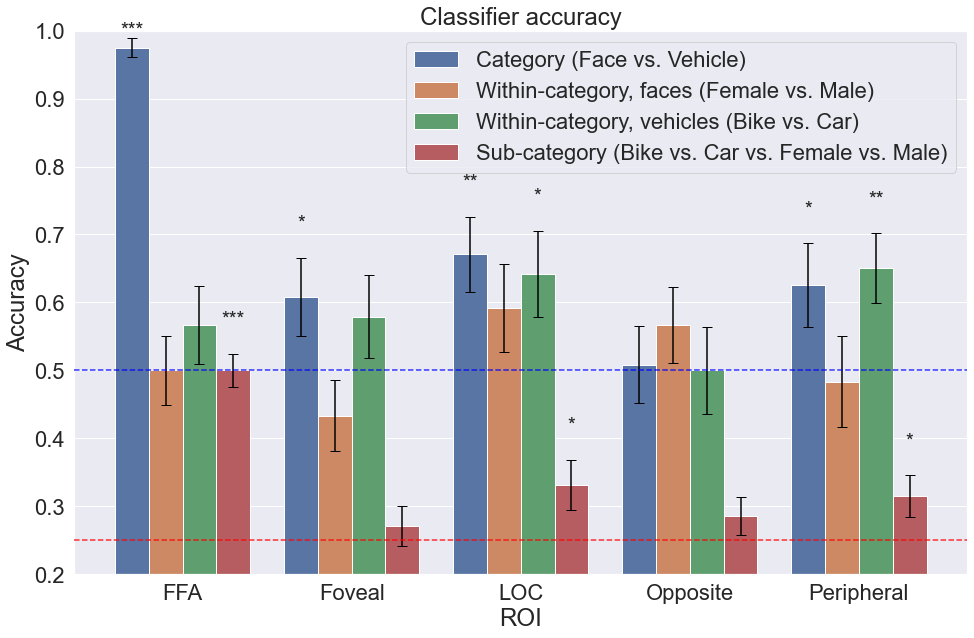

<IPython.core.display.Javascript object>

In [15]:
## PLOT AND SAVE FIG (ALL ROIS)
sns.set(font_scale=2)

# SET PLOTTING ORDER
graph_df['order'] = 0

graph_df.loc[graph_df['comparison'] == ('face', 'vehicle'), 'order'] = 0
graph_df.loc[graph_df['comparison'] == ('female', 'male'), 'order'] = 1
graph_df.loc[graph_df['comparison'] == ('bike', 'car'), 'order'] = 2
graph_df.loc[graph_df['comparison'] == ('bike', 'car', 'female', 'male'), 'order'] = 3

graph_df.sort_values(
    ['roi', 'order'], axis=0, inplace=True, ignore_index=True)

# INITIALIZE FIGURE
fig_dims = (16, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='roi', y='avg', hue='comparison', data=graph_df, ax=ax)

ax.set_ylabel('Accuracy')
ax.set_xlabel('ROI')
ax.set_title('Classifier accuracy')

# MAKE LEGEND
L = plt.legend()
L.get_texts()[0].set_text('Category (Face vs. Vehicle)')
L.get_texts()[1].set_text('Within-category, faces (Female vs. Male)')
L.get_texts()[2].set_text('Within-category, vehicles (Bike vs. Car)')
L.get_texts()[3].set_text('Sub-category (Bike vs. Car vs. Female vs. Male)')

# MAKE ERROR BARS (SEM)
x_pos = np.array([[ax.get_xticks()[i] - 0.3, ax.get_xticks()[i] - 0.1, + ax.get_xticks()[i] + 0.1, ax.get_xticks()[i] + 0.3, ]
                  for i in range(len(ax.get_xticks()))]).flatten()
y_pos = graph_df['avg']
yerr = np.array(graph_df['sem'])
plt.errorbar(x=x_pos, y=y_pos, yerr=yerr, fmt='none',
             c='black', capsize=5, palette="Paired")

# DEFINE PLOT RANGE AND PLOT CHANCE LINES (25%, 50%)
plt.ylim((0.2, 1))
plt.axhline(0.5, alpha=0.8, color='blue', ls='--', zorder=4)
plt.axhline(0.25, alpha=0.8, color='red', ls='--', zorder=4)

# DRAW SIGNIFICANCE ANNOTATIONS
for i, p in enumerate(graph_df['p']):
    if p < 0.001:
        displaystring = r'***'
    elif p < 0.01:
        displaystring = r'**'
    elif p < 0.05:
        displaystring = r'*'
    else:
        displaystring = r''
    height = graph_df['sem'][i] + graph_df['avg'][i] + 0.05
    if height > 1:
        height = 1
    plt.text(x_pos[
        i], height, displaystring, ha='center', va='center', size=20)
    
# SAVE THE FIGURE AND SHOW
if log == True:
    plt.savefig(os.path.join(out_dir, 'all_sem.png'))
    print(f'STEP: figures saved in {out_dir}')
plt.show()


In [14]:
if log == True:
    # SAVE PICKLED CONDITION FILE
    pkl_file = os.path.join(out_dir, os.path.basename(sys.argv[0]).split(
        '.')[0] + '_' + '-'.join(list(comparison)) + '_' + pipeline_dir + '_' + ts + '.pkl')
    with open(pkl_file, 'wb') as fp:
        pickle.dump(graph_df, fp)
    print('STEP: results dictionary saved as {pkl_file}')


<IPython.core.display.Javascript object>